In [1]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing.image import array_to_img, img_to_array, load_img

Using TensorFlow backend.


# モデル作成用関数

In [2]:
def get_teni_model(nb_classes,img_width=128, img_height=128):
    input_tensor = Input(shape=(img_width, img_height, 3))
    # include_top=False 出力層なし
    model = VGG16(include_top=False,classes=nb_classes, weights='imagenet',input_tensor=input_tensor)
    x=model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes, activation='softmax')(x)
    # VGG16とFC層を結合してモデルを作成（完成図が上の図）
    vgg_model= Model(input=model.input, output=x)

    # VGG16の図の青色の部分は重みを固定（frozen）
    for layer in vgg_model.layers[:15]:
        layer.trainable = False

    # 多クラス分類を指定
    vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

    return vgg_model

In [3]:
img_width, img_height = 128, 128

In [ ]:
# 学習済モデル読み込み
vgg_model = get_teni_model(2)
vgg_model.load_weights("vgg_model")

In [5]:
# 学習モード
K.set_learning_phase(1) #set learning phase

In [6]:
# Grad-Cam
# 以下を参考
# https://qiita.com/haru1977/items/45269d790a0ad62604b3
def Grad_Cam(input_model, x, layer_name):
    '''
    Args:
       input_model: モデルオブジェクト
       x: 画像(array)
       layer_name: 畳み込み層の名前

    Returns:
       jetcam_ret: 影響の大きい箇所を色付けした画像(array)
       jetcam : ヒートマップのみ(array)

    '''

    # 前処理
    ## 前処理の種類に応じて作成
    X = np.expand_dims(x, axis=0)

    X = X.astype('float32')
    preprocessed_input = X / 255.0
    #############

    # 予測クラスの算出

    predictions = input_model.predict(preprocessed_input,batch_size=1)
    class_idx = np.argmax(predictions[0])
    class_output = input_model.output[:, class_idx]


    #  勾配を取得
    conv_output = input_model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([input_model.input], [conv_output, grads])  # input_model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)


    # 画像化してヒートマップにして合成

    cam = cv2.resize(cam, (128, 128), cv2.INTER_LINEAR) # 画像サイズは200で処理したので
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam_ret = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return jetcam_ret,jetcam

In [7]:
x = img_to_array(load_img('./test/0/3D.png'))

In [8]:
X2 = np.expand_dims(x,axis=0)
X2.shape

(1, 128, 128, 3)

In [9]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

# GradCam

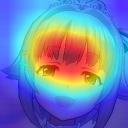

In [10]:
image,heat = Grad_Cam(vgg_model, x,  "block5_conv3")
array_to_img(image)

In [11]:
# ヒートマップ

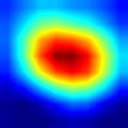

In [12]:
array_to_img(heat)